# CTM MILP Formulation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *
from ctmmodels.delaythroughput import DelayThroughputAltPhasing as CTMModel

## Using the Module

In [2]:
model = CTMModel(
    r_left=0.3,
    r_through=0.4,
    r_right=0.3,
    alpha=0.2
)
model.generate()

In [3]:
model.solve(log_output=True)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 2544 rows and 412 columns.
MIP Presolve modified 772 coefficients.
Aggregator did 388 substitutions.
Reduced MIP has 2840 rows, 1600 columns, and 12484 nonzeros.
Reduced MIP has 360 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (14.65 ticks)
Found incumbent of value 456.988244 after 0.04 sec. (31.36 ticks)
Probing time = 0.00 sec. (0.53 ticks)
Tried aggregator 1 time.
Reduced MIP has 2840 rows, 1600 columns, and 12484 nonzeros.
Reduced MIP has 360 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.00 ticks)
Probing time = 0.02 sec. (0.53 ticks)
Clique table members: 240.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.18 sec. (162.90 ticks)

        Nodes                                         Cuts/


3.6533401012420654

## Showing the Cell Capacities

In [4]:
df_x, df_y, df_g = model.return_solution()

In [5]:
df_x_source = df_x[df_x.cell == (CELL_SOURCE,0,1)].sort_values(by='timestep')
df_x_normal0 = df_x[df_x.cell == (CELL_NORMAL,0,1)].sort_values(by='timestep')
df_x_normal1 = df_x[df_x.cell == (CELL_NORMAL,1,1)].sort_values(by='timestep')
df_x_normal2 = df_x[df_x.cell == (CELL_NORMAL,2,1)].sort_values(by='timestep')
df_x_left = df_x[df_x.cell == (CELL_MOVEMENT,THROUGH_TURN,1)].sort_values(by='timestep')
df_x_sink = df_x[df_x.cell == model.S[(CELL_MOVEMENT,THROUGH_TURN,1)][0]].sort_values(by='timestep')

df_x_approach = df_x_source.append(df_x_normal1).append(df_x_normal2).append(df_x_normal0).append(df_x_left).append(df_x_sink)
df_x_approach = df_x_approach.pivot(index='timestep', columns='cell', values='volume')
df_x_approach

cell,"(0, 0, 1)","(1, 0, 3)","(2, 1, 1)","(3, 0, 1)","(3, 1, 1)","(3, 2, 1)"
timestep,,,,,,
0,1.333333,0.000000,0.000000,0.0,0.0,0.000000
1,1.666667,0.000000,0.000000,1.0,0.0,0.000000
2,2.000000,0.000000,0.000000,1.0,1.0,0.000000
3,2.333333,0.000000,0.000000,1.0,1.0,1.000000
4,2.666667,0.000000,0.333333,1.0,1.0,1.166667
5,3.000000,0.000000,0.666667,1.0,1.0,1.333333
6,3.333333,0.250000,0.750000,1.0,1.0,1.500000
7,3.666667,0.500000,0.583333,1.0,1.0,1.666667
8,4.000000,0.500000,0.416667,1.0,1.0,1.833333


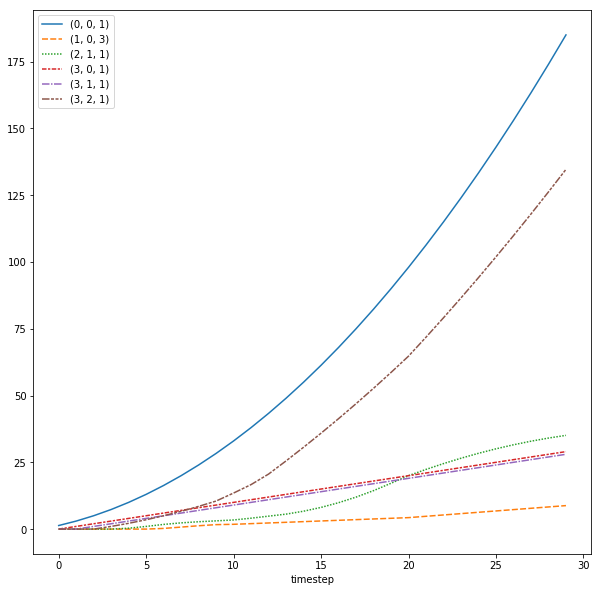

In [6]:
_, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=df_x_approach.cumsum())

This linear, cascading cumulative sum of consecutive cells (except for the through cell) means that the turning ratio is working fine.

In [7]:
df_y_source = df_y[df_y.cell_from == (CELL_SOURCE,0,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal0 = df_y[df_y.cell_from == (CELL_NORMAL,0,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal1 = df_y[df_y.cell_from == (CELL_NORMAL,1,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal2 = df_y[df_y.cell_from == (CELL_NORMAL,2,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal2 = df_y[df_y.cell_from == (CELL_NORMAL,2,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_left = df_y[df_y.cell_from == (CELL_MOVEMENT,THROUGH_TURN,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_sink = df_y[df_y.cell_from == model.S[(CELL_MOVEMENT,THROUGH_TURN,1)][0]].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')

df_y_approach = df_y_source.append(df_y_normal1).append(df_y_normal2).append(df_y_normal0).append(df_y_left).append(df_y_sink)
df_y_approach.reset_index(inplace=True)
df_y_approach = df_y_approach.pivot(index='timestep', columns='cell_from', values='flow')
df_y_approach

cell_from,"(0, 0, 1)","(2, 1, 1)","(3, 0, 1)","(3, 1, 1)","(3, 2, 1)"
timestep,,,,,
0,1.0,0.000000,0.0,0.0,0.000000
1,1.0,0.000000,1.0,0.0,0.000000
2,1.0,0.000000,1.0,1.0,0.000000
3,1.0,0.000000,1.0,1.0,0.833333
4,1.0,0.000000,1.0,1.0,0.833333
5,1.0,0.250000,1.0,1.0,0.833333
6,1.0,0.500000,1.0,1.0,0.833333
7,1.0,0.500000,1.0,1.0,0.833333
8,1.0,0.416667,1.0,1.0,0.833333


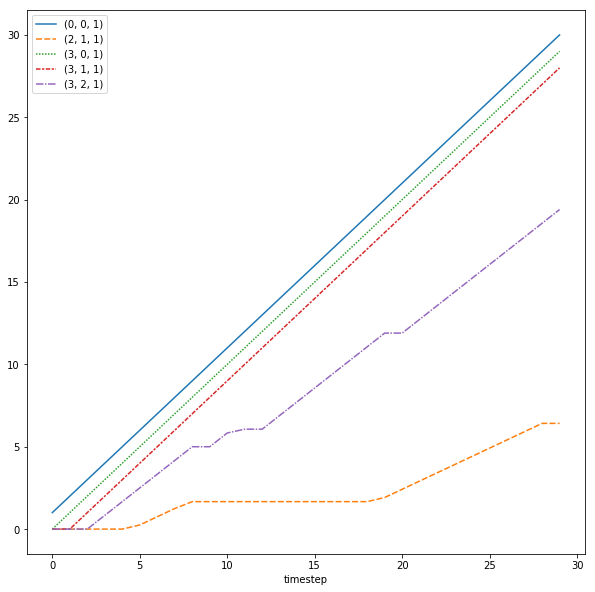

In [8]:
_, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=df_y_approach.cumsum())

### Comparing the Green Signal and the Flow

In [9]:
df_g_specific = df_g[df_g.cell == (1,0,1)].sort_values(by='timestep')
df_g_specific.cell = df_g_specific.cell.apply(lambda x: (CELL_MOVEMENT,THROUGH_TURN,1))
df_y_specific = df_y[(df_y.cell_from == (CELL_MOVEMENT,THROUGH_TURN,1)) & (df_y.cell_to == model.S[(CELL_MOVEMENT,THROUGH_TURN,1)][0])].sort_values(by='timestep')
df_y_specific = df_y_specific.groupby(['timestep', 'cell_from']).agg({'flow': 'sum'}).reset_index()

df_g_y = pd.merge(df_g_specific, df_y_specific, left_on=['timestep', 'cell'], right_on=['timestep', 'cell_from'])[
    ['timestep', 'is_green', 'flow']
]

df_g_y.set_index('timestep', inplace=True)

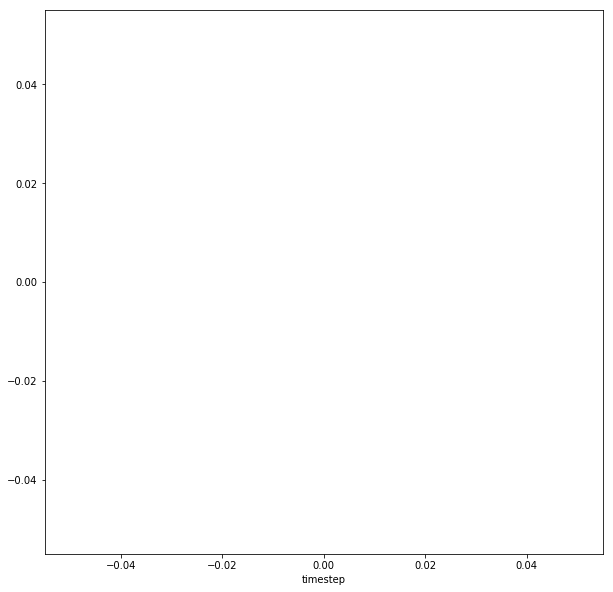

In [10]:
_, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=df_g_y)

## Checking the green times of the 8 phases

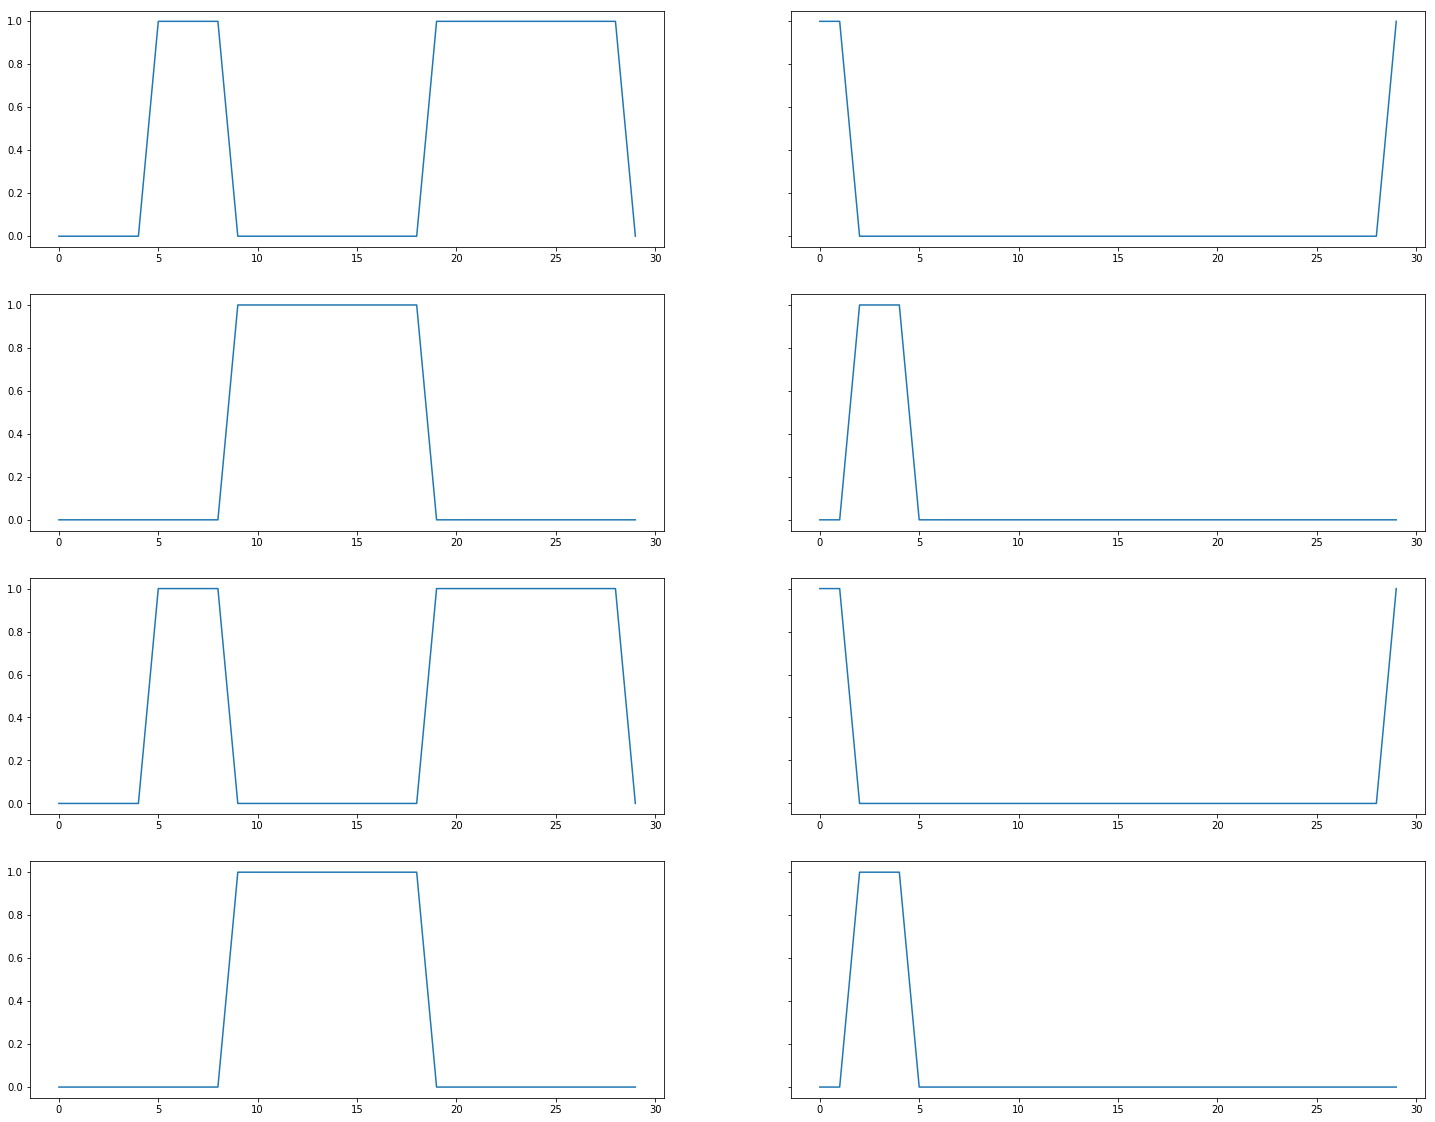

In [21]:
df_g_map = df_g.pivot(index='timestep', columns='cell', values='is_green')
throughs = [intToBinTuple(x) for x in [1,3,5,7]]
lefts = [intToBinTuple(x) for x in [0,2,4,6]]

_, axs = plt.subplots(4,2,figsize=(25,20), sharey=True)

for ndx, t in enumerate(throughs):
    sns.lineplot(data=df_g_map[t], ax=axs[ndx][0])
    
for ndx, l in enumerate(lefts):
    sns.lineplot(data=df_g_map[l], ax=axs[ndx][1])